In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
import datetime as dt

from copy import deepcopy

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn import linear_model

# used to calculate AUROC/accuracy
from sklearn import metrics

# local utils
import utils

import xgboost as xgb

import pickle

# default colours/marker/linestyles for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

## Load data

In [6]:
print('=== MIMIC ===')
df_mimic = pd.read_csv('X_mimic_day1.csv.gz', sep=',', index_col=0)
var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']

# convenient reference to death column
y_mimic = df_mimic['death'].values
X_mimic = df_mimic.drop(var_other, axis=1).values

print('{:5s} - {} observations. Outcome rate: {:2.2f}%.'.format(
        'mimic', X_mimic.shape[0], 100.0*np.mean(y_mimic)))

print('=== eICU ===')
df_eicu = pd.read_csv('X_eicu_day1.csv.gz', sep=',', index_col=0)

hosp_to_keep = df_eicu['hospitalid'].value_counts()
hosp_to_keep = hosp_to_keep[hosp_to_keep>=100].index.values
print('Retaining {} of {} hospitals with at least 100 patients.'.format(
    len(hosp_to_keep), df_eicu['hospitalid'].nunique()))

df_eicu = df_eicu.loc[df_eicu['hospitalid'].isin(hosp_to_keep), :]

var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']

# convenient reference to death column
y_eicu = df_eicu['death'].values
X_eicu = df_eicu.drop(var_other,axis=1).values

print('{:5s} - {} observations. Outcome rate: {:2.2f}%.'.format(
        'eICU', X_eicu.shape[0], 100.0*np.mean(y_eicu)))

=== MIMIC ===
mimic - 27940 observations. Outcome rate: 9.57%.
=== eICU ===
Retaining 119 of 179 hospitals with at least 100 patients.
eICU  - 67540 observations. Outcome rate: 7.47%.


In [7]:
df_mimic.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,0,20.081944,4,125.50,98.50,58.50,65.500000,30.000000,39.555554,...,98.0,15.0,8614.0,0,48.2940,0,0,0,0,0
200009,0,0,6.177083,1,94.80,124.60,82.20,98.000000,14.000000,34.920000,...,100.0,15.0,6090.0,1,47.5548,0,0,0,0,1
200014,0,0,4.604861,1,71.75,114.25,65.25,81.583351,11.000000,35.625000,...,100.0,14.0,1566.0,0,84.7301,0,0,0,1,0
200019,0,1,2.904861,2,79.00,175.00,45.00,88.333298,16.000000,34.277778,...,100.0,10.0,1719.0,1,82.8820,0,0,0,0,0
200021,1,0,1.948611,1,82.00,105.00,77.50,83.500000,16.666667,35.222222,...,100.0,15.0,13805.0,0,60.8501,0,0,0,0,0


In [23]:
def train_model(df, target='death', features=None):
    """
    Given a dataframe, trains a logistic regression model using all features.
    
    Features can be optionally specified with the `features` argument
    """
    
    y = df[target].values
    if features is None:
        features = df.columns

    # by default, exclude the target in the features
    features = [x for x in features if x != target]
        
    X = df[features].values
    
    # train model
    #base_mdl = linear_model.LogisticRegressionCV(Cs=10, penalty='l2', cv=5)
    base_mdl = linear_model.LogisticRegression(penalty='l2')
    
    mdl = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ('model', base_mdl)]) 

    # train model
    mdl = mdl.fit(X, y)
    
    return mdl

In [24]:
def predict_with_model(mdl, df, target='death', features=None):
    """
    Given a model and dataframe, output predictions for a specific set of features.
    
    Features can be optionally specified with the `features` argument
    """
    
    y = df[target].values
    if features is None:
        features = df.columns

    # by default, exclude the target in the features
    features = [x for x in features if x != target]
        
    X = df[features].values
    
    prob = mdl.predict_proba(X)[:,1]
    
    return prob

In [173]:
def evaluate_predictions(prob, df, target='death'):
    """
    Given a set of predictions, evaluate their quality.
    
    Returns a dictionary of statistics.
    """
    
    y = df[target]
    
    d = dict()
    
    # calculate SMR
    d['count'] = y.count()
    d['outcome'] = y.sum()
    
    d['smr'] = y.sum() / prob.sum()
    d['mse'] = metrics.mean_squared_error(y, prob)
    d['mae'] = metrics.mean_absolute_error(y, prob)
    d['logloss'] = metrics.log_loss(y, prob)
    if len(np.unique(y))<=1:
        d['auc'] = np.nan
    else:
        d['auc'] = metrics.roc_auc_score(y, prob)
    return d
    

# Experiments

## 1. Time (CareVue -> MetaVision)

1. Train model on CareVue
2. Calculate predictions on MetaVision
3. Evaluate performance

In [25]:
# training dataframe
df_train = df_mimic.loc[df_mimic['hospitalid']==0, :]
df_test = df_mimic.loc[df_mimic['hospitalid']==1, :]

# define features
features = [x for x in df_mimic.columns if x not in ['hospitalid', 'death', 'hosp_los', 'ventdays']]

mdl = train_model(df_train, target='death', features=features)
prob = predict_with_model(mdl, df_test, target='death', features=features)
perf = evaluate_predictions(prob, df_test, target='death')

print('Train on CareVue, evaluate on MetaVision.')
for p in perf:
    print('{:20s}: {}'.format(p, perf[p]))

Train on CareVue, evaluate on MetaVision.
outcome             : 1080
auc                 : 0.8763853135486211
count               : 11698
smr                 : 0.9910391652931377


## 2. Space (eICU <-> eICU)

In [26]:
df_eicu.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141194,73,0,9.340972,0,104.0,131.0,73.0,89.333333,18.0,36.6,...,100.0,NaN,16750.0,0,68.0,0,0,0,1,0
141233,73,0,16.224306,2,89.0,92.0,55.0,81.666667,16.0,36.1,...,100.0,10.0,8510.0,1,81.0,0,0,0,1,1
141265,63,0,11.175000,0,83.0,143.0,89.0,111.000000,12.0,36.7,...,97.0,15.0,8835.0,0,67.0,0,0,0,1,0
141284,73,0,1.895833,0,96.0,128.0,60.0,78.500000,26.0,36.6,...,99.0,NaN,2450.0,0,63.0,0,0,0,1,0
141340,63,0,5.346528,0,59.0,180.0,84.0,79.666667,16.0,36.1,...,99.0,14.0,1265.0,1,80.0,0,0,0,1,1


,auc,count,outcome,smr
0,0.876385,11698,1080,0.991039


In [42]:
# evaluate on one hospital
df_test = df_eicu.loc[df_eicu['hospitalid']==73, :]

# define features
features = [x for x in df_eicu.columns if x not in ['hospitalid', 'death', 'hosp_los', 'ventdays']]

results = None
# train model with a bunch of different hospitals
hospital_list = df_eicu['hospitalid'].unique()
for h in hospital_list:
    if h == 73:
        continue
    
    df_train = df_eicu.loc[df_eicu['hospitalid']==h, :]

    mdl = train_model(df_train, target='death', features=features)
    prob = predict_with_model(mdl, df_test, target='death', features=features)
    perf = evaluate_predictions(prob, df_test, target='death')
    
    # append perf to a dataframe
    if results is None:
        results = pd.DataFrame(perf, index=[h])
    else:
        results = pd.concat([results, pd.DataFrame(perf, index=[h])])
    
# add original data size to results
n_hosp = df_eicu.groupby('hospitalid')[['death']].count()
n_hosp.columns = ['n_train']
results = results.merge(n_hosp, how='inner', left_index=True, right_index=True)
results.head()

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


,auc,count,outcome,smr,n_train
63,0.667745,3006,113,0.580151,447
66,0.555127,3006,113,0.931525,322
68,0.741803,3006,113,0.529857,176
71,0.574952,3006,113,1.118866,205
67,0.616422,3006,113,0.702802,116


In [34]:
import seaborn as sns

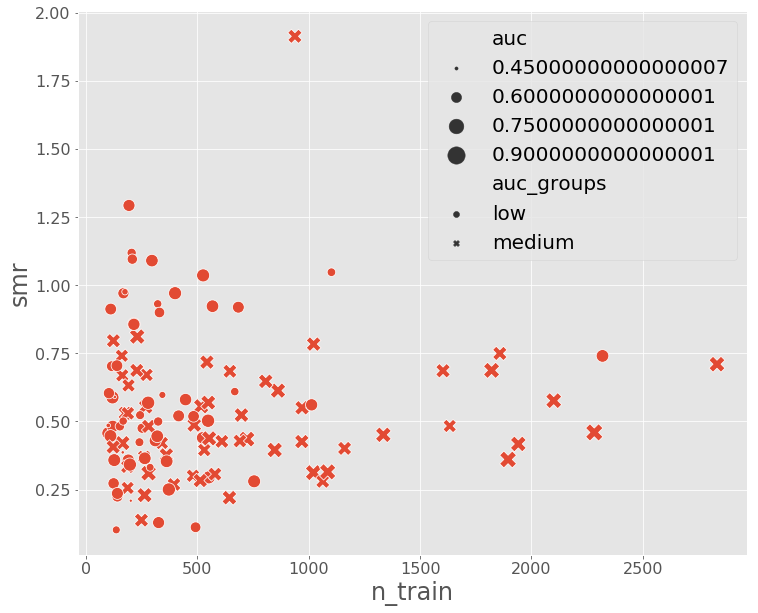

In [68]:
# plot different symbols based on performance
ranges = {'low': [0, 0.7],
         'medium': [0.7, 0.9],
         'high': [0.9, 1.0]}

styles = ['x', 's', 'o', 'd']
results['auc_groups'] = 'low'

for i, rlbl in enumerate(ranges):
    r = ranges[rlbl]
    idx = (results['auc']>=r[0]) & (results['auc']<r[1])
    results.loc[idx, 'auc_groups'] = rlbl
    
plt.figure(figsize=[12,10])
sns.scatterplot(data=results, style='auc_groups',
                x='n_train', y='smr', size='auc', sizes=(10, 300))
plt.show()

## 3. Time and space (eICU 2014 -> eICU 2015)

# Transfer model from another hospital to this one

### Train hospital specific models

Training the models first might help with caching.

In [69]:
# train model with a bunch of different hospitals
mdls = dict()
hospital_list = df_eicu['hospitalid'].unique()
for h in hospital_list:
    df_train = df_eicu.loc[df_eicu['hospitalid']==h, :]

    mdl = train_model(df_train, target='death', features=features)
    mdls[h] = mdl

### Create a matrix of performance measures

In [237]:
H = len(hospital_list)
perf = np.zeros([H, H])

for i, h in enumerate(hospital_list):
    print('{}..'.format(h), end=' ')
    mdl = mdls[h]
    for j, h2 in enumerate(hospital_list):
        df_test = df_eicu.loc[df_eicu['hospitalid']==h2, :]
        
        prob = predict_with_model(mdl, df_test, target='death', features=features)
        p = evaluate_predictions(prob, df_test, target='death')
        
        perf[i, j] = p['auc']
        
print('done!')

# turn into dataframe
perf = pd.DataFrame(perf, columns=hospital_list, index=hospital_list)
perf.sort_index(inplace=True)
cols = perf.index.values
perf = perf[cols]

73.. 63.. 66.. 68.. 71.. 67.. 59.. 69.. 58.. 92.. 79.. 110.. 122.. 144.. 142.. 141.. 143.. 140.. 148.. 146.. 176.. 167.. 157.. 154.. 165.. 152.. 171.. 181.. 183.. 184.. 180.. 188.. 196.. 198.. 194.. 195.. 197.. 202.. 199.. 206.. 200.. 208.. 210.. 220.. 217.. 226.. 227.. 243.. 244.. 245.. 252.. 248.. 253.. 249.. 251.. 264.. 266.. 256.. 259.. 254.. 258.. 281.. 272.. 279.. 283.. 280.. 282.. 269.. 271.. 277.. 275.. 307.. 312.. 310.. 300.. 301.. 303.. 318.. 338.. 345.. 331.. 328.. 336.. 400.. 394.. 387.. 384.. 390.. 388.. 407.. 383.. 392.. 

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


396.. 386.. 405.. 389.. 413.. 412.. 411.. 416.. 417.. 420.. 421.. 422.. 424.. 419.. 440.. 435.. 429.. 434.. 436.. 439.. 443.. 452.. 444.. 449.. 445.. 458.. 459.. done!


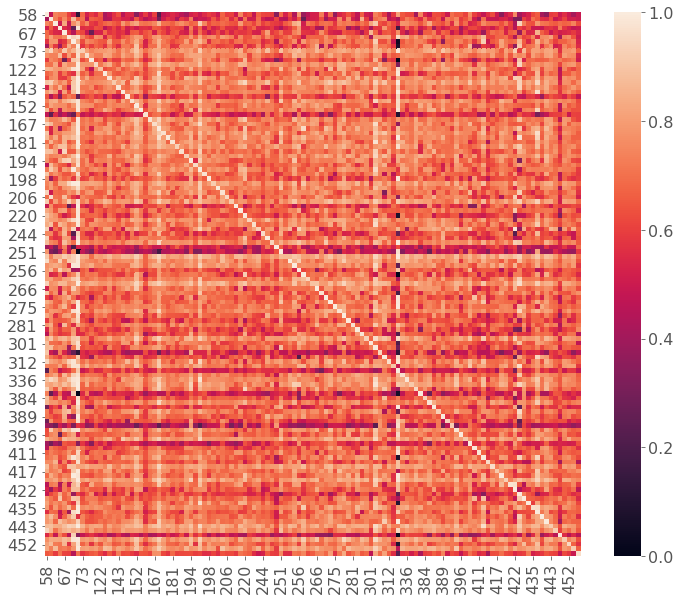

In [238]:
plt.figure(figsize=[12,10])
sns.heatmap(perf)
plt.show()

Above we have AUROC of a model trained on the y-axis hospitals and evaluating on the x-axis hospitals. The diagonal is an AUROC ~0.9-1.0 because train/test on the same dataset.

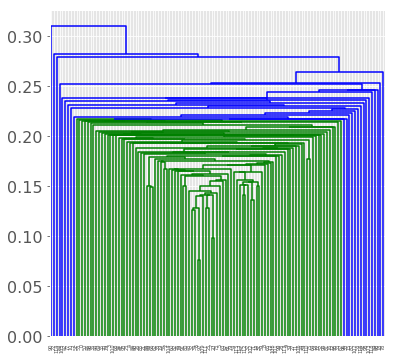

In [263]:
# make symmetric by using min( Xij, Xji )
perf_sym = np.zeros(perf.shape)
for i in range(perf_sym.shape[0]):
    for j in range(perf_sym.shape[1]):
        if i==j:
            perf_sym[i, j] = 0
        else:
            # invert the auroc
            perf_sym[i, j] = 1 - min([perf.iloc[i,j], perf.iloc[j,i]])

import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(perf_sym) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j


from polo import optimal_leaf_ordering
#D = ... your distance matrix
optimal_Z = optimal_leaf_ordering(Z, distArray)
plt.figure(figsize=[6,6])
dn = dendrogram(optimal_Z)
plt.show()

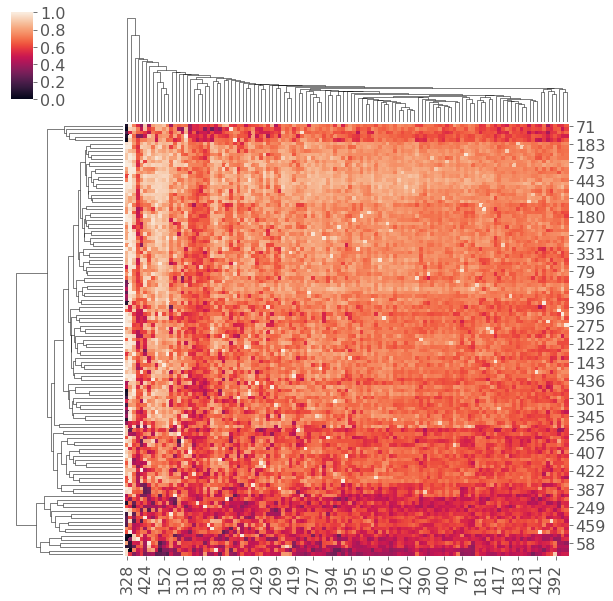

In [262]:
sns.clustermap(perf)

## Train a model on all *but* one hospital

In [86]:
# train model with a bunch of different hospitals
mdls_excl = dict()
hospital_list = df_eicu['hospitalid'].unique()
for h in hospital_list:
    df_train = df_eicu.loc[df_eicu['hospitalid']!=h, :]

    mdl = train_model(df_train, target='death', features=features)
    mdls_excl[h] = mdl
    print('{}..'.format(h), end=' ')
    
print('done!')

73.. 63.. 66.. 68.. 71.. 67.. 59.. 69.. 58.. 92.. 79.. 110.. 122.. 144.. 142.. 141.. 143.. 140.. 148.. 146.. 176.. 167.. 157.. 154.. 165.. 152.. 171.. 181.. 183.. 184.. 180.. 188.. 196.. 198.. 194.. 195.. 197.. 202.. 199.. 206.. 200.. 208.. 210.. 220.. 217.. 226.. 227.. 243.. 244.. 245.. 252.. 248.. 253.. 249.. 251.. 264.. 266.. 256.. 259.. 254.. 258.. 281.. 272.. 279.. 283.. 280.. 282.. 269.. 271.. 277.. 275.. 307.. 312.. 310.. 300.. 301.. 303.. 318.. 338.. 345.. 331.. 328.. 336.. 400.. 394.. 387.. 384.. 390.. 388.. 407.. 383.. 392.. 396.. 386.. 405.. 389.. 413.. 412.. 411.. 416.. 417.. 420.. 421.. 422.. 424.. 419.. 440.. 435.. 429.. 434.. 436.. 439.. 443.. 452.. 444.. 449.. 445.. 458.. 459.. done!


In [174]:
H = len(hospital_list)
perf = np.zeros([H, H])

results_excl = None

for i, h in enumerate(hospital_list):
    print('{}..'.format(h), end=' ')
    mdl = mdls_excl[h]
    
    df_test = df_eicu.loc[df_eicu['hospitalid']==h, :]
    prob = predict_with_model(mdl, df_test, target='death', features=features)
    p = evaluate_predictions(prob, df_test, target='death')
    
    # append perf to a dataframe
    if results_excl is None:
        results_excl = pd.DataFrame(p, index=[h])
    else:
        results_excl = pd.concat([results_excl, pd.DataFrame(p, index=[h])])

print('done!')

73.. 63.. 66.. 68.. 71.. 67.. 59.. 69.. 58.. 92.. 79.. 110.. 122.. 144.. 142.. 141.. 143.. 140.. 148.. 146.. 176.. 167.. 157.. 154.. 165.. 152.. 171.. 181.. 183.. 184.. 180.. 188.. 196.. 198.. 194.. 195.. 197.. 202.. 199.. 206.. 200.. 208.. 210.. 220.. 217.. 226.. 227.. 243.. 244.. 245.. 252.. 248.. 253.. 249.. 251.. 264.. 266.. 256.. 259.. 254.. 258.. 281.. 272.. 279.. 283.. 280.. 282.. 269.. 271.. 277.. 275.. 307.. 312.. 310.. 300.. 301.. 303.. 318.. 338.. 345.. 331.. 328.. 336.. 400.. 394.. 387.. 384.. 390.. 388.. 407.. 383.. 392.. 396.. 386.. 405.. 389.. 413.. 412.. 411.. 416.. 417.. 420.. 421.. 422.. 424.. 419.. 440.. 435.. 429.. 434.. 436.. 439.. 443.. 452.. 444.. 449.. 445.. 458.. 459.. done!


In [223]:
# apache data
a_eicu = pd.read_csv('eicu_apache.csv', sep=',', index_col=0)

results_apache = None

for i, h in enumerate(hospital_list):
    print('{}..'.format(h), end=' ')    
    df_test = df_eicu.loc[df_eicu['hospitalid']==h, :]
    
    # add apache to df_test
    df_test = df_test.merge(a_eicu[['predictedhospitalmortality']], how='left', left_index=True, right_index=True)
    if df_test['predictedhospitalmortality'].isnull().sum()>0:
        print('{}  has {} null apache scores.'.format(h, df_test['predictedhospitalmortality'].isnull().sum()))
    prob = df_test['predictedhospitalmortality'].values
    p = evaluate_predictions(prob, df_test, target='death')
    
    # append perf to a dataframe
    if results_apache is None:
        results_apache = pd.DataFrame(p, index=[h])
    else:
        results_apache = pd.concat([results_apache, pd.DataFrame(p, index=[h])])

print('done!')

73.. 63.. 66.. 68.. 71.. 67.. 59.. 69.. 58.. 92.. 79.. 110.. 122.. 144.. 142.. 141.. 143.. 140.. 148.. 146.. 176.. 167.. 157.. 154.. 165.. 152.. 171.. 181.. 183.. 184.. 180.. 188.. 196.. 198.. 194.. 195.. 197.. 202.. 199.. 206.. 200.. 208.. 210.. 220.. 217.. 226.. 227.. 243.. 244.. 245.. 252.. 248.. 253.. 249.. 251.. 264.. 266.. 256.. 259.. 254.. 258.. 281.. 272.. 279.. 283.. 280.. 282.. 269.. 271.. 277.. 275.. 307.. 312.. 310.. 300.. 301.. 303.. 318.. 338.. 345.. 331.. 328.. 336.. 400.. 394.. 387.. 384.. 390.. 388.. 407.. 383.. 392.. 396.. 386.. 405.. 389.. 413.. 412.. 411.. 416.. 417.. 420.. 421.. 422.. 424.. 419.. 440.. 435.. 429.. 434.. 436.. 439.. 443.. 452.. 444.. 449.. 445.. 458.. 459.. done!


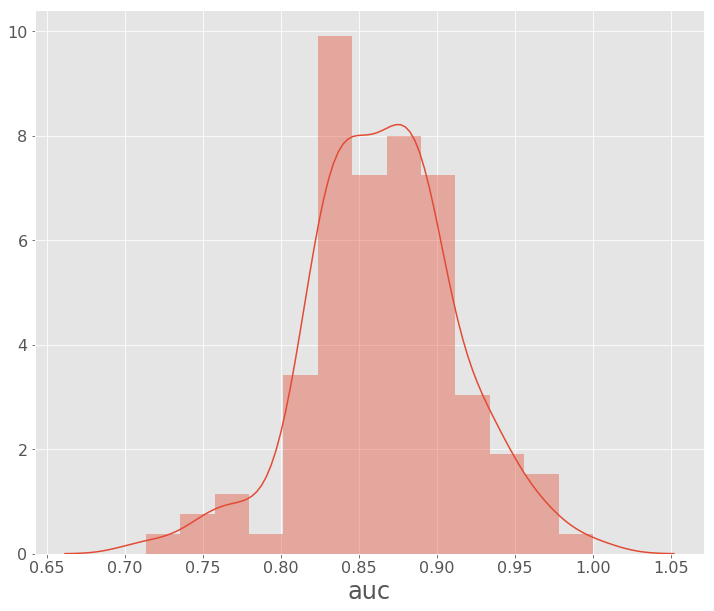

In [104]:
plt.figure(figsize=[12,10])
sns.distplot(results_excl['auc'])
plt.show()

Above is distribution of AUROC when training on all eICU hospitals *but* one, and evaluating on that one held out hospital.

In [232]:
# hospital level data
h_eicu = pd.read_csv('eicu_hospital_data.csv', sep=',', index_col=0)

# convert columns into binary
cols = ['numbedscategory', 'region']
for c in cols:
    # add a "nan" group
    h_eicu.loc[h_eicu[c].isnull(), c] = 'null'
    
    # loop through groups and create dummy vars
    col_list = h_eicu[c].unique()
    for b in col_list:
        h_eicu[c + '_' + b] = (h_eicu[c] == b).astype(int)

    h_eicu.drop(c, axis=1, inplace=True)
    
    # drop the most frequent category
    col_list = [c + '_' + b for b in col_list]
    ref_grp = h_eicu[col_list].sum().idxmax()
    print('{:30s} - setting to reference as it is the biggest group (n={}).'.format(ref_grp, h_eicu[ref_grp].sum()))
    h_eicu.drop(ref_grp, axis=1, inplace=True)
    
# change teaching status to 0/1
h_eicu['teachingstatus'] = (h_eicu['teachingstatus'] == 't').astype(int)

numbedscategory_100 - 249      - dropping as it is the biggest group (n=61).
region_Midwest                 - dropping as it is the biggest group (n=66).


## Can we predict how well a model will generalize?

Try to predict the AUROC of a model on a held out hospital using only high level hospital info (region, bed size, etc).

In [220]:
def plot_perf_predictability(measure, apache=False, min_pat=None, ignore_cols=None):
    """
    evaluate how predictable held out performance is using APACHE or trained model
    
    requires: results_apache, results_excl h_eicu
    """
    
    if apache:
        X = h_eicu.merge(results_apache[[measure]], how='inner', left_index=True, right_index=True)
    else:
        # use trained model
        X = h_eicu.merge(results_excl[[measure]], how='inner', left_index=True, right_index=True)
    
    if min_pat is not None:
        idx = X['num_pat']>=min_pat
        X = X.loc[idx, :]
        
    if ignore_cols is not None:
        # manually remove some columns
        cols = [c for c in X.columns if c not in ignore_cols]
        X = X[cols]
        
    #X = [number of patients, ICU type, mortality rate, disease variance, ethnicities, gender, region, teaching hospital, bed size, age]
    y = X[measure]

    base_mdl = linear_model.LinearRegression()

    mdl = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ('model', base_mdl)]) 

    # train model
    mdl = mdl.fit(X.drop(measure, axis=1).values, y)
    prob = mdl.predict(X.drop(measure, axis=1).values)

    # plot errors
    plt.figure(figsize=[12,10])
    sns.regplot(y, prob, label='r2 = {:0.3f}'.format(metrics.r2_score(y, prob)))
    plt.xlabel('True {}'.format(measure))
    plt.ylabel('Predicted {}'.format(measure))
    #plt.plot([0.7,1], [0.7,1], 'k--')
    xlim = plt.xlim()
    plt.plot(xlim, xlim, 'k--')
    plt.legend()
    plt.show()
    
    for i, c in enumerate(mdl.named_steps['model'].coef_):
        print('{:2.4f} - {}'.format(c, X.columns[i]))

In [210]:
h_eicu.head()

,teachingstatus,num_pat,frac_mortality,age,race_black,race_hispanic,race_asian,race_other,electivesurgery,is_female,numbedscategory_<100,numbedscategory_null,numbedscategory_>= 500,numbedscategory_250 - 499,region_null,region_South,region_West,region_Northeast
hospitalid,,,,,,,,,,,,,,,,,,
56,0,110,0.072727,66.154545,0.000000,0.009091,0.000000,0.990909,0.090909,0.536364,1,0,0,0,0,0,0,0
58,0,146,0.061644,54.479452,0.013699,0.034247,0.034247,0.917808,0.034247,0.486301,0,0,0,0,0,0,0,0
59,0,216,0.027778,65.601852,0.009259,0.027778,0.013889,0.949074,0.263889,0.481481,1,0,0,0,0,0,0,0
60,0,119,0.033613,63.075630,0.008403,0.067227,0.000000,0.924370,0.058824,0.428571,1,0,0,0,0,0,0,0
61,0,81,0.024691,61.975309,0.000000,0.012346,0.012346,0.975309,0.049383,0.518519,1,0,0,0,0,0,0,0


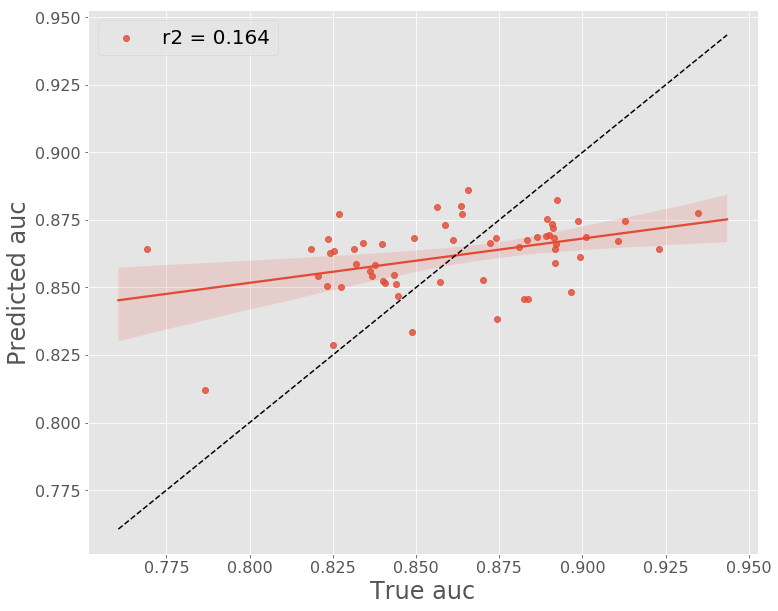

0.0060 - teachingstatus
-0.0032 - age
-0.0014 - race_black
0.0009 - race_hispanic
0.0008 - race_asian
-0.0057 - electivesurgery
0.0001 - is_female
0.0000 - numbedscategory_<100
-0.0085 - numbedscategory_null
-0.0035 - numbedscategory_>= 500
-0.0004 - numbedscategory_250 - 499
0.0039 - region_null
-0.0057 - region_South
-0.0060 - region_West
-0.0019 - region_Northeast


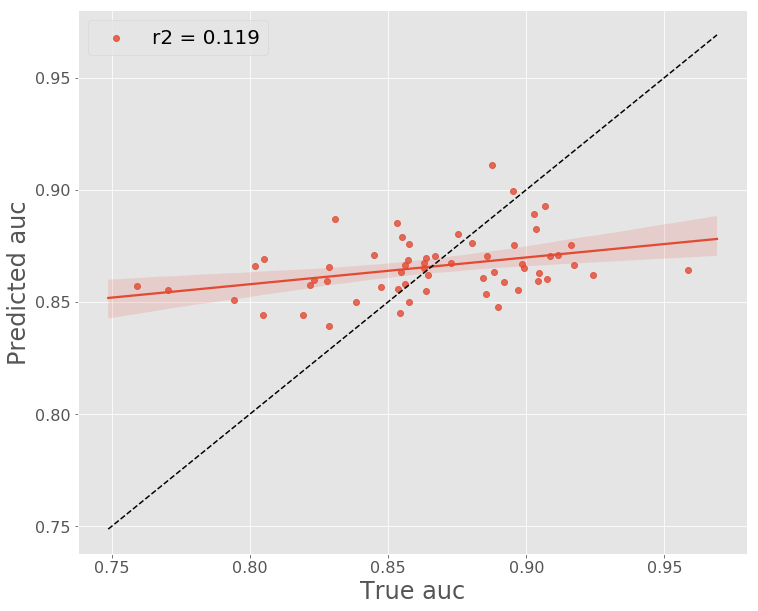

-0.0025 - teachingstatus
-0.0071 - age
0.0010 - race_black
0.0043 - race_hispanic
0.0010 - race_asian
0.0032 - electivesurgery
0.0077 - is_female
-0.0000 - numbedscategory_<100
-0.0021 - numbedscategory_null
0.0029 - numbedscategory_>= 500
0.0002 - numbedscategory_250 - 499
0.0036 - region_null
-0.0016 - region_South
0.0021 - region_West
0.0102 - region_Northeast


In [224]:
measure = 'auc'
plot_perf_predictability(measure, min_pat=500, apache=False,
                         ignore_cols=['race_other', 'num_pat', 'frac_mortality'])
plot_perf_predictability(measure, min_pat=500, apache=True,
                         ignore_cols=['race_other', 'num_pat', 'frac_mortality'])

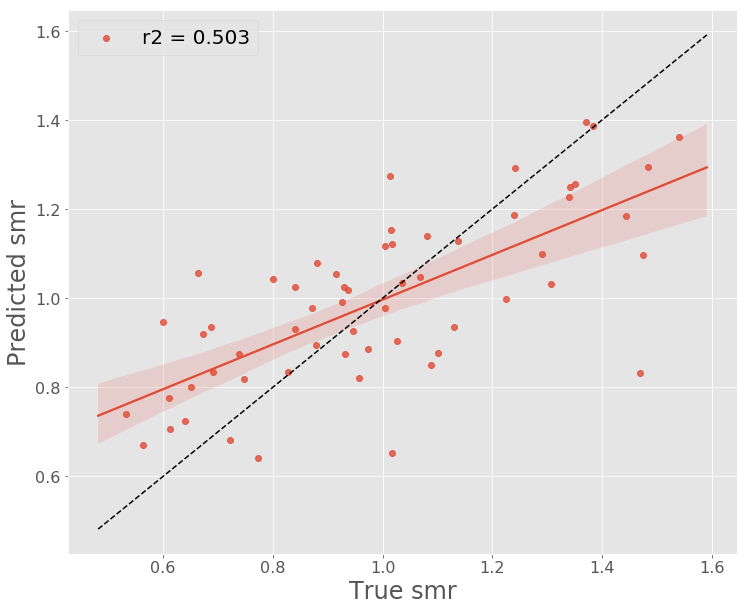

-0.0672 - teachingstatus
-0.0223 - age
0.0517 - race_black
0.0191 - race_hispanic
-0.0406 - race_asian
-0.0181 - electivesurgery
0.0635 - is_female
-0.0000 - numbedscategory_<100
0.0270 - numbedscategory_null
0.1527 - numbedscategory_>= 500
0.0206 - numbedscategory_250 - 499
0.0425 - region_null
0.0395 - region_South
0.1481 - region_West
0.1242 - region_Northeast


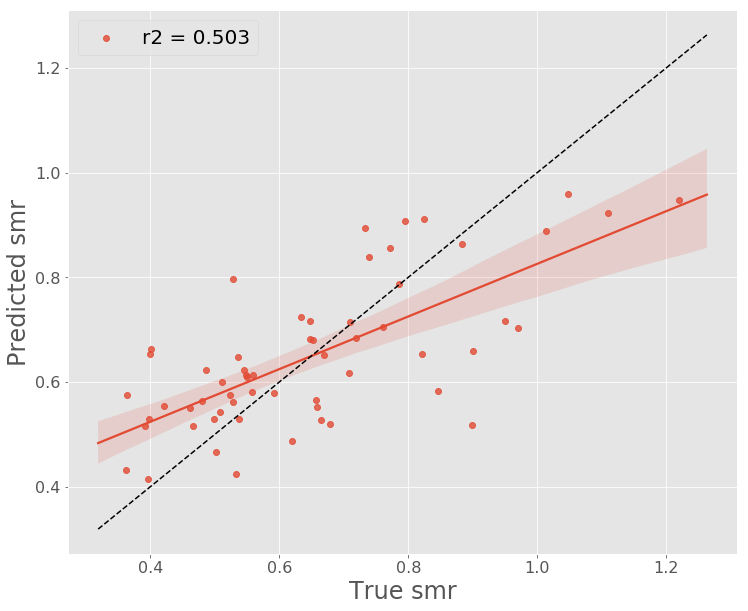

-0.0118 - teachingstatus
-0.0073 - age
0.0460 - race_black
0.0039 - race_hispanic
-0.0589 - race_asian
-0.0086 - electivesurgery
0.0239 - is_female
-0.0000 - numbedscategory_<100
-0.0059 - numbedscategory_null
0.0214 - numbedscategory_>= 500
-0.0121 - numbedscategory_250 - 499
0.0441 - region_null
0.0300 - region_South
0.1467 - region_West
0.1048 - region_Northeast


In [227]:
# can't use SMR in this experiment since this is inflated by shifting the intercept according to the % mortality
# see below
measure = 'smr'
plot_perf_predictability(measure, min_pat=500, apache=False,
                         ignore_cols=['race_other', 'num_pat', 'frac_mortality'])
plot_perf_predictability(measure, min_pat=500, apache=True,
                         ignore_cols=['race_other', 'num_pat', 'frac_mortality'])

below explains that (1) SMR is easily predicted by using the % mortality of the new dataset, since we seem to know what our model outputs on average, but (2) AUC is not!

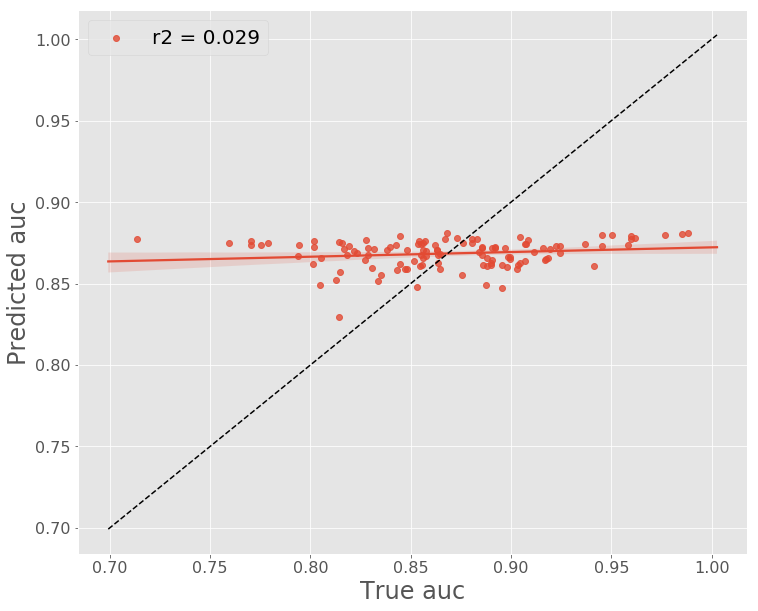

-0.0085 - frac_mortality


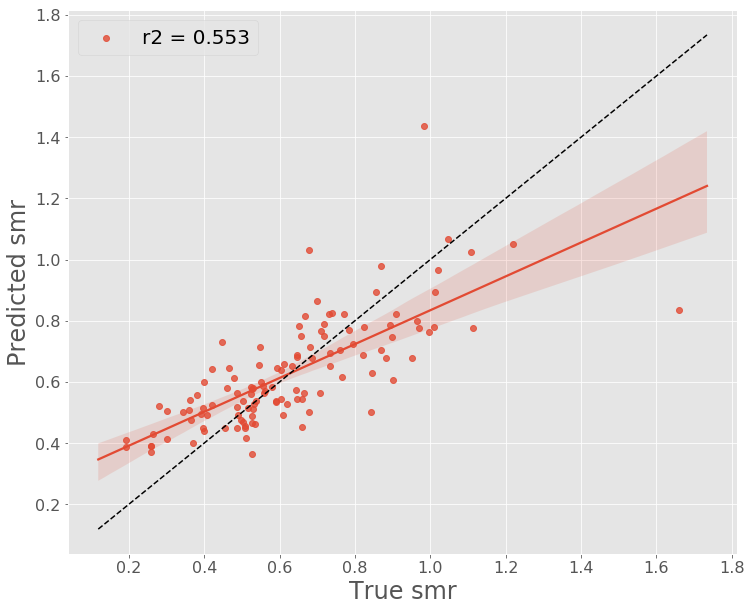

0.1747 - frac_mortality


In [231]:
measure = 'auc'
plot_perf_predictability(measure, apache=True,
                         ignore_cols=[x for x in h_eicu.columns if x != 'frac_mortality'])
measure = 'smr'
plot_perf_predictability(measure, apache=True,
                         ignore_cols=[x for x in h_eicu.columns if x != 'frac_mortality'])

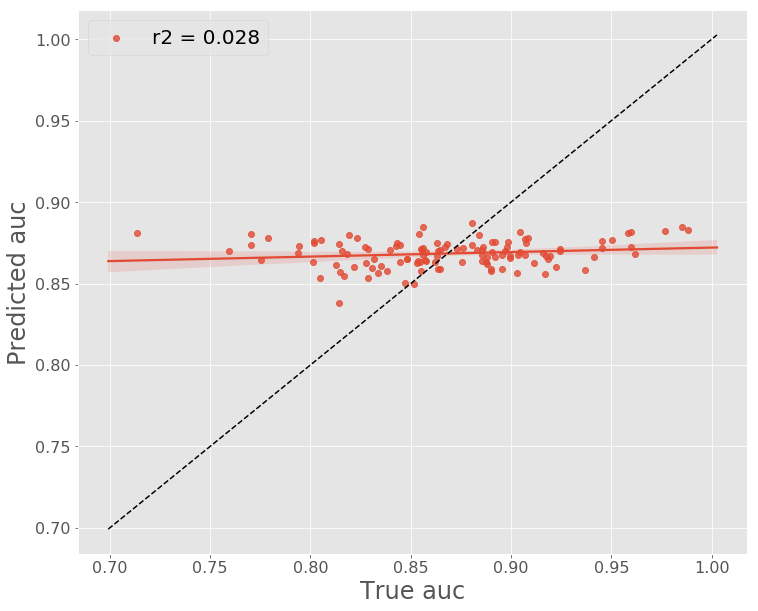

-0.0083 - apachescore


In [235]:
measure = 'auc'
plot_perf_predictability(measure, apache=True,
                         ignore_cols=[x for x in h_eicu.columns if x != 'apachescore'])

### Pick a hospital

We'll choose one hospital, then

1. apply all other models on that hospital
2. define a sampling regime
3. evaluate (a) local and (b) transferred models
  * train a model one sample at a time using just that hospital's data
  * re-train the other models one sample at a time

In [276]:
# Select the hospital to evaluate on
hospital = 73

pt = df_eicu.loc[df_eicu['hospitalid'] == hospital, :].index.values

# reshuffle patients
seed = 1292
np.random.seed(seed)
pt = pt[np.random.permutation(pt.shape[0])]
print('{} patients in hospital {}.'.format(pt.shape[0], hospital))

# get optimal performance on the entire hospital
print('\nOptimal performance:')
print(results_excl.loc[hospital, :])

3006 patients in hospital 73.

Optimal performance:
auc           0.891022
count      3006.000000
logloss       0.121196
mae           0.073303
mse           0.030985
outcome     113.000000
smr           0.673375
Name: 73, dtype: float64


In [293]:
a_eicu.head()

,hospitalid,apachescore,predictedhospitalmortality
patientunitstayid,,,
141203,66,90,0.470973
141208,73,17,0.002249
141233,73,66,0.035490
141265,63,36,0.052292
141276,63,55,0.095662


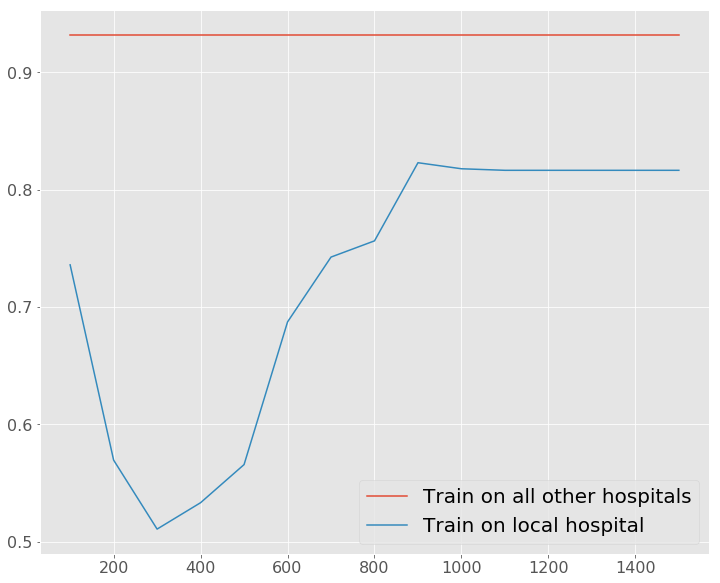

In [301]:
# each sample will increment by N_PT patients
N_PT = 100

xi = [i for i in range(N_PT, pt.shape[0], N_PT)]

improvement_curve_local = np.zeros(len(xi))
improvement_curve_excl  = np.zeros(len(xi))

df_hosp = df_eicu.loc[df_eicu['hospitalid'] == hospital, :]
df_hosp = df_hosp.merge(a_eicu[['predictedhospitalmortality']], how='inner',
                       left_index=True, right_index=True)

features_keep = features #['predictedhospitalmortality']

# fix a test set
pt_test = pt[-500:]
pt = pt[0:-500]
    
# evaluate on all patients in this bin
df_test  = df_hosp.loc[pt_test, :]

for i, n in enumerate(xi):
        
    df_train = df_hosp.loc[pt[0:n], :]
    
    # evaluate the pre-trained model
    mdl = mdls_excl[hospital]
    prob = predict_with_model(mdl, df_test, target='death', features=features)
    p = evaluate_predictions(prob, df_test, target='death')
    improvement_curve_excl[i] = p['auc']
    
    # fit a model with patients up to i
    mdl = train_model(df_train, target='death', features=features_keep)
    prob = predict_with_model(mdl, df_test, target='death', features=features_keep)
    p = evaluate_predictions(prob, df_test, target='death')
    
    improvement_curve_local[i] = p['auc']
    
# plot the result
plt.figure(figsize=[12, 10])
sns.lineplot(xi, improvement_curve_excl, label='Train on all other hospitals')
sns.lineplot(xi, improvement_curve_local, label='Train on local hospital')
plt.show()

## Gradient Boosting

We use hyper-parameters selected by cross-validation for xgboost. These parameters are (with best reported parameter across 5 folds in brackets):

```
if os.path.exists('xgb_mdl.pkl'):
    with open('xgb_mdl.pkl', 'rb') as fp:
        xgb_mdl = pickle.load(fp)
else:
    np.random.seed(739)

    xgb_mdl = xgb.XGBClassifier(colsample_bytree=0.7, silent=1,
                                learning_rate = 0.01, n_estimators=1000,
                                subsample=0.8, max_depth=9)


    # train model
    xgb_mdl = xgb_mdl.fit(X, y)
    xgb_prob = xgb_mdl.predict_proba(X)[:,1]
    auc = metrics.roc_auc_score(y, xgb_prob)

    auc = metrics.roc_auc_score(y, xgb_prob)
    print('Training set AUROC: {:0.3f}'.format(auc))
    with open('xgb_mdl.pkl', 'wb') as fp:
        pickle.dump(xgb_mdl, fp)
```

# Old, unupdated code to produce bubble plots

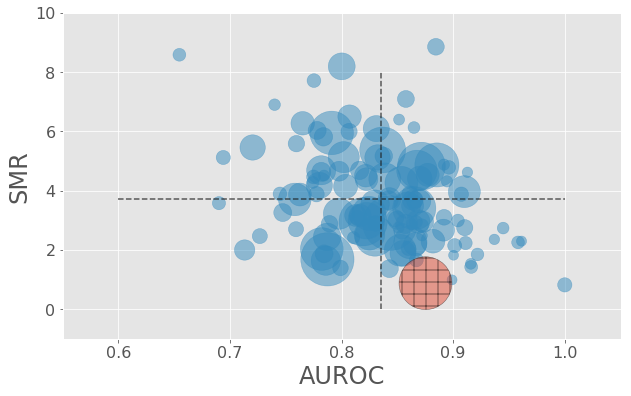

Average AUROC: 0.835
Average SMR: 3.716


In [96]:
# create a bubble plot AUROC vs SMR
plt.figure(figsize=[10,6])
plt.scatter( h_stats['auc'], h_stats['smr'],
            s=np.ceil(h_stats['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD',
           label='eICU hospitals')

# add original performance
plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
            s=X_mimic.shape[0]/10, hatch='+',
            marker='o', edgecolors='k', alpha=0.5, color='#E24A33',
            label='MIMIC-III')

# lines for mean performance
plt.plot( (h_stats['auc']).mean()*np.ones(2), [0,8], '--', color=[0.1,0.1,0.1],alpha=0.7)
plt.plot( [0.6,1.0], (h_stats['smr']).mean()*np.ones(2), '--', color=[0.1,0.1,0.1],alpha=0.7)


plt.yticks(np.linspace(0, 10, 6))
plt.xticks(np.linspace(0.6, 1, 5))
plt.ylim([-1,10])
plt.xlim([0.55,1.05])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

print('Average AUROC: {:0.3f}'.format((h_stats['auc']).mean()))
print('Average SMR: {:0.3f}'.format((h_stats['smr']).mean()))

### Normalize eICU hospital wise before applying MIMIC model

In [22]:
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].unique()
for h in hosp_list:
    idxKeep = df_eicu['hospitalid'] == h
    
    # get current hosp data
    X_current = X_eicu[idxKeep, :]
    
    # refit the imputer
    lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)
    
    # work-around for imputer dropping columns with all NaN
    X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)
    
    idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
    if np.any(idxAllNan==0):
        X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
        for i, idx in enumerate(np.where(idxAllNan>0)[0]):
            X_fix[:, idx] = X_current_t[:, i]
    else:
        X_fix = X_current_t
    
    # refit the scaler
    lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)
    
    X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)
    
    curr_prob = lr_mdl_hn.named_steps['model'].predict_proba(X_fix)[:,1]
    
    prob[idxKeep] = curr_prob
    
# add predictions to dataframe
df_eicu['prob_norm'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_normed = df_eicu.drop('prob',axis=1).rename({'prob_norm': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob_norm'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob_norm'].sum()))

eICU overall AUROC: 0.844
eICU overall SMR:   0.755


### Retrain model for each hospital

In [23]:
# normalize eICU hospital wise before applying MIMIC model
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].unique()

for h in hosp_list:
    idxKeep = df_eicu['hospitalid'] == h
    
    if len(np.unique(y_eicu[idxKeep]))<2:
        prob[idxKeep] = np.nan
        continue
    
    # get current hosp data
    X_current = X_eicu[idxKeep, :]
    
    # refit the imputer
    lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)
    
    # work-around for imputer dropping columns with all NaN
    X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)
    
    idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
    if np.any(idxAllNan==0):
        X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
        for i, idx in enumerate(np.where(idxAllNan>0)[0]):
            X_fix[:, idx] = X_current_t[:, i]
    else:
        X_fix = X_current_t
    
    # refit the scaler
    lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)
    
    X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)
    
    # refit the model
    
    if 'LogisticRegression' in str(type(lr_mdl_hn.named_steps['model'])):
        # don't do CV again, just use the C_ penalty
        l2penalty = lr_mdl_hn.named_steps['model'].C_[0]
        new_model = linear_model.LogisticRegression(penalty='l2', C=l2penalty).fit(X_fix, y_eicu[idxKeep])
    else:
        new_model = lr_mdl_hn.named_steps['model'].fit(X_fix, y_eicu[idxKeep])
    
    curr_prob = new_model.predict_proba(X_fix)[:,1]
    
    prob[idxKeep] = curr_prob
    
# add predictions to dataframe
df_eicu['prob_retrain'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_retrain = df_eicu.drop('prob',axis=1).rename({'prob_retrain': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob_norm'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob_norm'].sum()))

eICU overall AUROC: 0.844
eICU overall SMR:   0.755


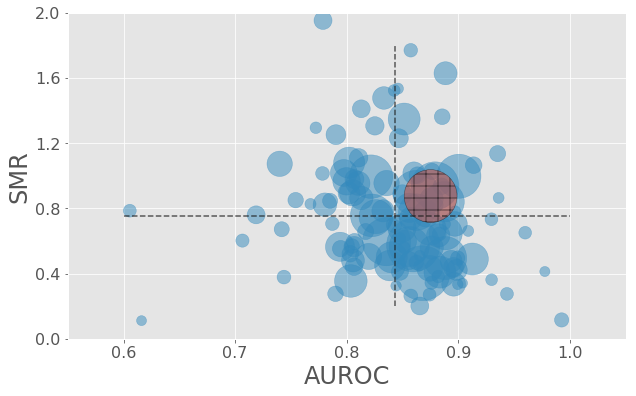

Average AUROC: 0.835
Average SMR: 3.716


In [103]:
# create a bubble plot AUROC vs SMR
plt.figure(figsize=[10,6])
plt.scatter( h_stats_normed['auc'], h_stats_normed['smr'],
            s=np.ceil(h_stats_normed['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD',
           label='eICU hospitals')

# add original performance
plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
            s=X_mimic.shape[0]/10, hatch='+',
            marker='o', edgecolors='k', alpha=0.5, color='#E24A33',
            label='MIMIC-III')

# lines for mean performance
plt.plot( (h_stats_normed['auc']).mean()*np.ones(2), [0.2,1.8], '--', color=[0.1,0.1,0.1],alpha=0.7)
plt.plot( [0.6,1.0], (h_stats_normed['smr']).mean()*np.ones(2), '--', color=[0.1,0.1,0.1],alpha=0.7)


plt.yticks(np.linspace(0, 2, 6))
plt.xticks(np.linspace(0.6, 1, 5))
plt.ylim([0,2])
plt.xlim([0.55,1.05])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

print('Average AUROC: {:0.3f}'.format((h_stats['auc']).mean()))
print('Average SMR: {:0.3f}'.format((h_stats['smr']).mean()))

## Lines in direction of improvement

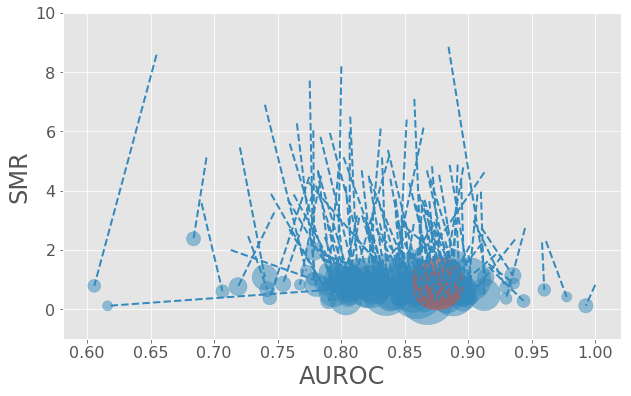

0.008 [-0.005 - 0.025] AUROC improvement
2.960 [1.891 - 3.690] SMR improvement


In [47]:
# draw lines from original to renormed preds
plt.figure(figsize=[10,6])

for h in hosp_to_keep:
    plt.plot([h_stats.loc[h, 'auc'], h_stats_normed.loc[h, 'auc']],
             [h_stats.loc[h, 'smr'], h_stats_normed.loc[h, 'smr']],
            marker=None, linestyle='--', linewidth=2, color='#348ABd')
    
plt.scatter( h_stats_normed['auc'], h_stats_normed['smr'],
            s=np.ceil(h_stats_normed['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
            s=X_mimic.shape[0]/10, marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.linspace(0, 10, 6))
plt.ylim([-1,10])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

auc_improvement = (h_stats_normed['auc'] - h_stats['auc'])
print('{:0.3f} [{:0.3f} - {:0.3f}] AUROC improvement'.format(
    auc_improvement.mean(), auc_improvement.quantile(0.25), auc_improvement.quantile(0.75)))

smr_improvement = - ((h_stats_normed['smr'] - h_stats['smr']))
print('{:0.3f} [{:0.3f} - {:0.3f}] SMR improvement'.format(
    smr_improvement.mean(), smr_improvement.quantile(0.25), smr_improvement.quantile(0.75)))

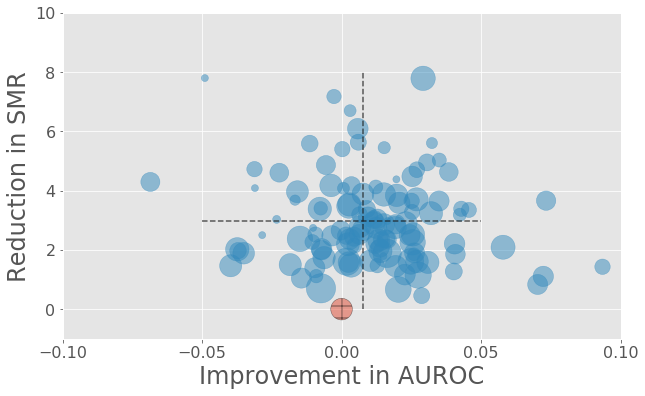

In [77]:
def auc_as_size(x):
    # ensure 0.75 -> 100 and 0.9 -> 1000
    x = x-0.75
    x = np.clip(x, 0, 0.9)
    x = x/0.9
    x = 3000*x+50
    return x

plt.figure(figsize=[10,6])
plt.scatter(-(h_stats['auc'] - h_stats_normed['auc']),
             h_stats['smr'] - h_stats_normed['smr'],
            s=auc_as_size(h_stats_normed['auc']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )
# add original performance
plt.scatter( 0, 0, s=auc_as_size(cv_perf.loc['l2','auc']),
         marker='o', alpha=0.5, color='#E24A33',
            hatch='+', edgecolors='k')


plt.plot( -(h_stats['auc'] - h_stats_normed['auc']).mean()*np.ones(2), [0,8], '--', color=[0.1,0.1,0.1],alpha=0.7)
plt.plot( [-0.05, 0.05], (h_stats['smr'] - h_stats_normed['smr']).mean()*np.ones(2), '--', color=[0.1,0.1,0.1],alpha=0.7)

plt.yticks(np.linspace(0, 10, 6))
plt.xticks(np.linspace(-.1, .1, 5))
plt.ylim([-1,10])
plt.xlim([-.1,.1])
plt.ylabel('Reduction in SMR')
plt.xlabel('Improvement in AUROC')
plt.show()

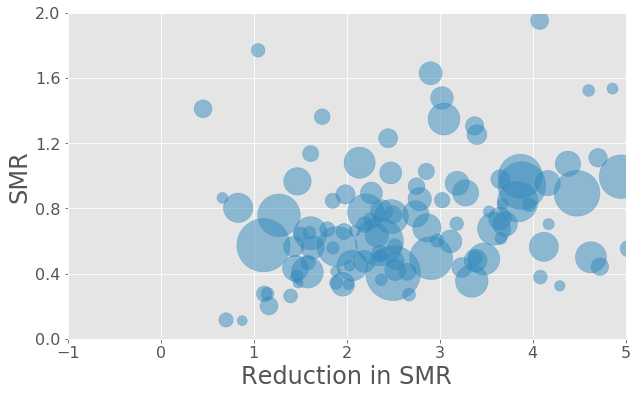

In [67]:
plt.figure(figsize=[10,6])
plt.scatter(h_stats['smr'] - h_stats_normed['smr'],
            h_stats_normed['smr'],
            s=np.ceil(h_stats_normed['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
#plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
#            s=X.shape[0]/10,
#         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.linspace(0, 2.0, 6))
plt.ylim([0,2])
plt.xlim([-1,5])
plt.ylabel('SMR')
plt.xlabel('Reduction in SMR')
plt.show()

## Retrain once, on largest hospital, then predict

In [75]:
# normalize eICU hospital wise before applying MIMIC model
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].value_counts()
h = hosp_list.idxmax() # biggest hospital

idxKeep = df_eicu['hospitalid'] == h

# get current hosp data
X_current = X_eicu[idxKeep, :]

# refit the imputer
lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)

# work-around for imputer dropping columns with all NaN
X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)

idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
if np.any(idxAllNan==0):
    X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
    for i, idx in enumerate(np.where(idxAllNan>0)[0]):
        X_fix[:, idx] = X_current_t[:, i]
else:
    X_fix = X_current_t

# refit the scaler
lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)

X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)

# refit the model
if 'LogisticRegression' in str(type(lr_mdl_hn.named_steps['model'])):
    # don't do CV again, just use the C_ penalty
    l2penalty = lr_mdl_hn.named_steps['model'].C_[0]
    new_model = linear_model.LogisticRegression(penalty='l2', C=l2penalty).fit(X_fix, y_eicu[idxKeep])
else:
    new_model = lr_mdl_hn.named_steps['model'].fit(X_fix, y_eicu[idxKeep])

# now that we have new_model, apply to original data
X_current = lr_mdl_hn.named_steps['imputer'].transform(X_eicu)
X_current = lr_mdl_hn.named_steps['scaler'].transform(X_current)
prob = new_model.predict_proba(X_current)[:,1]

df_eicu['prob_retrain_eicu'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_retrain_eicu = df_eicu.drop('prob',axis=1).rename({'prob_retrain_eicu': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)
h_stats_retrain_eicu.sort_values('count',ascending=False).head()

,auc,count,outcome,smr
hospitalid,,,,
73,0.914891,3006.0,113.0,0.625180
264,0.810663,2833.0,164.0,0.902484
338,0.816516,2319.0,127.0,0.863382
443,0.867447,2282.0,235.0,1.127024
458,0.825613,2100.0,185.0,1.283303


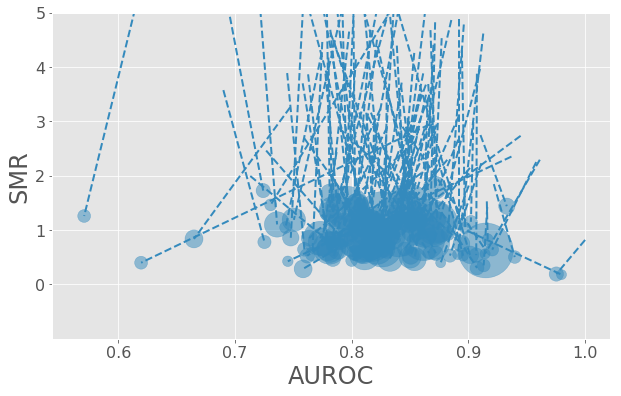

-0.010 [-0.031 - 0.017] AUROC improvement
2.810 [1.814 - 3.472] SMR improvement


In [69]:
# draw lines from original to retrained preds
plt.figure(figsize=[10,6])

for h in hosp_to_keep:
    plt.plot([h_stats.loc[h, 'auc'], h_stats_retrain_eicu.loc[h, 'auc']],
             [h_stats.loc[h, 'smr'], h_stats_retrain_eicu.loc[h, 'smr']],
            marker=None, linestyle='--', linewidth=2, color='#348ABd')
    
plt.scatter(h_stats_retrain_eicu['auc'], h_stats_retrain_eicu['smr'],
            s=np.ceil(h_stats_retrain_eicu['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
#plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
#            s=X.shape[0]/10,
#         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.arange(0, 6, 1))
plt.ylim([-1,5])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

auc_improvement = (h_stats_retrain_eicu['auc'] - h_stats['auc'])
print('{:0.3f} [{:0.3f} - {:0.3f}] AUROC improvement'.format(
    auc_improvement.mean(), auc_improvement.quantile(0.25), auc_improvement.quantile(0.75)))

smr_improvement = - ((h_stats_retrain_eicu['smr'] - h_stats['smr']))
print('{:0.3f} [{:0.3f} - {:0.3f}] SMR improvement'.format(
    smr_improvement.mean(), smr_improvement.quantile(0.25), smr_improvement.quantile(0.75)))

build a funnel plot models

```python
# create a funnel plot
idxKeep = h_stats['outcome']>=10

plt.figure(figsize=[10,6])
plt.scatter( h_stats.loc[idxKeep, 'count'], h_stats.loc[idxKeep, 'smr'],
            s=np.ceil(h_stats.loc[idxKeep, 'count']),
            marker='o', edgecolor=None, alpha=0.5, color='#348ABD' )

# draw 95% confidence intervals
# 95% CI = SMR_se * 1.96
xi = np.arange(10, 3000, 10)
plt.plot( xi, np.ones(xi.shape), '--', color=[0.2,0.2,0.2], linewidth=4, alpha=0.8)
plt.plot( xi, 1.0 + (np.sqrt(xi) / xi * 1.96), '--', color='#E24A33', linewidth=4, alpha=0.8 )
plt.plot( xi, 1.0 - (np.sqrt(xi) / xi * 1.96), '--', color='#E24A33', linewidth=4, alpha=0.8 )

plt.yticks([0, 1, 2, 3])
plt.ylim([-0.1,10])
plt.ylabel('SMR')
plt.xlabel('Number of ICU patients admitted')
plt.show()
```